In [13]:
import os
import shutil
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Conv2D, Multiply
from tensorflow.keras.models import Model
from keras.layers import Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from PIL import Image 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import label_binarize
from tensorflow.keras import regularizers
from keras.optimizers.legacy import Adam 
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, auc, recall_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve, average_precision_score

In [14]:
# Dataset Directory
data_dir = './DATASET/'
class_labels = ['Covid', 'Normal', 'Pneumonia', 'Tuberculosis']
num_classes = 4

In [15]:
# Count the number of images per class
class_counts = {}
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    num_images = len(os.listdir(class_dir))
    class_counts[label] = num_images

In [16]:
# Create a data frame from the class counts
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df.index.name = 'Class'
df = df.reset_index()

# Print the table


print("Number of Images per Class:")
print(df)

# Calculate total number of images
total_images = df['Count'].sum()
print(f"\nTotal Number of Images: {total_images}")

Number of Images per Class:
          Class  Count
0         Covid  11956
1        Normal  10753
2     Pneumonia  11263
3  Tuberculosis   8757

Total Number of Images: 42729


In [17]:
class_counts

{'Covid': 11956, 'Normal': 10753, 'Pneumonia': 11263, 'Tuberculosis': 8757}

/var/folders/9l/vgkv1v8n3dz46sjj8rl_rqzw0000gn/T/ipykernel_82213/4031396680.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df, palette='viridis')


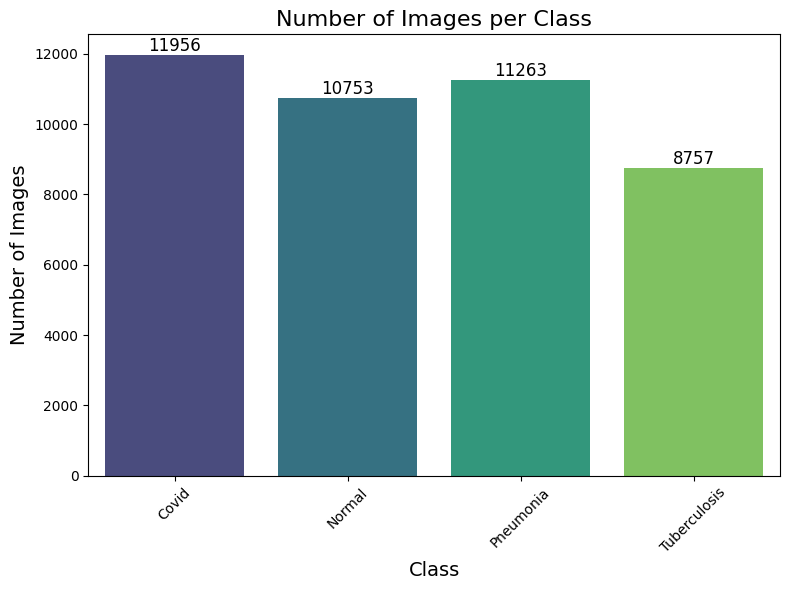

In [18]:
# Graph to illustrate dataset 
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Class', y='Count', data=df, palette='viridis')
ax.set_title('Number of Images per Class', fontsize=16)
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(df['Count']):
    ax.text(i, v + 0.2, str(v), fontsize=12, ha='center', va='bottom')

plt.tight_layout()
plt.show()

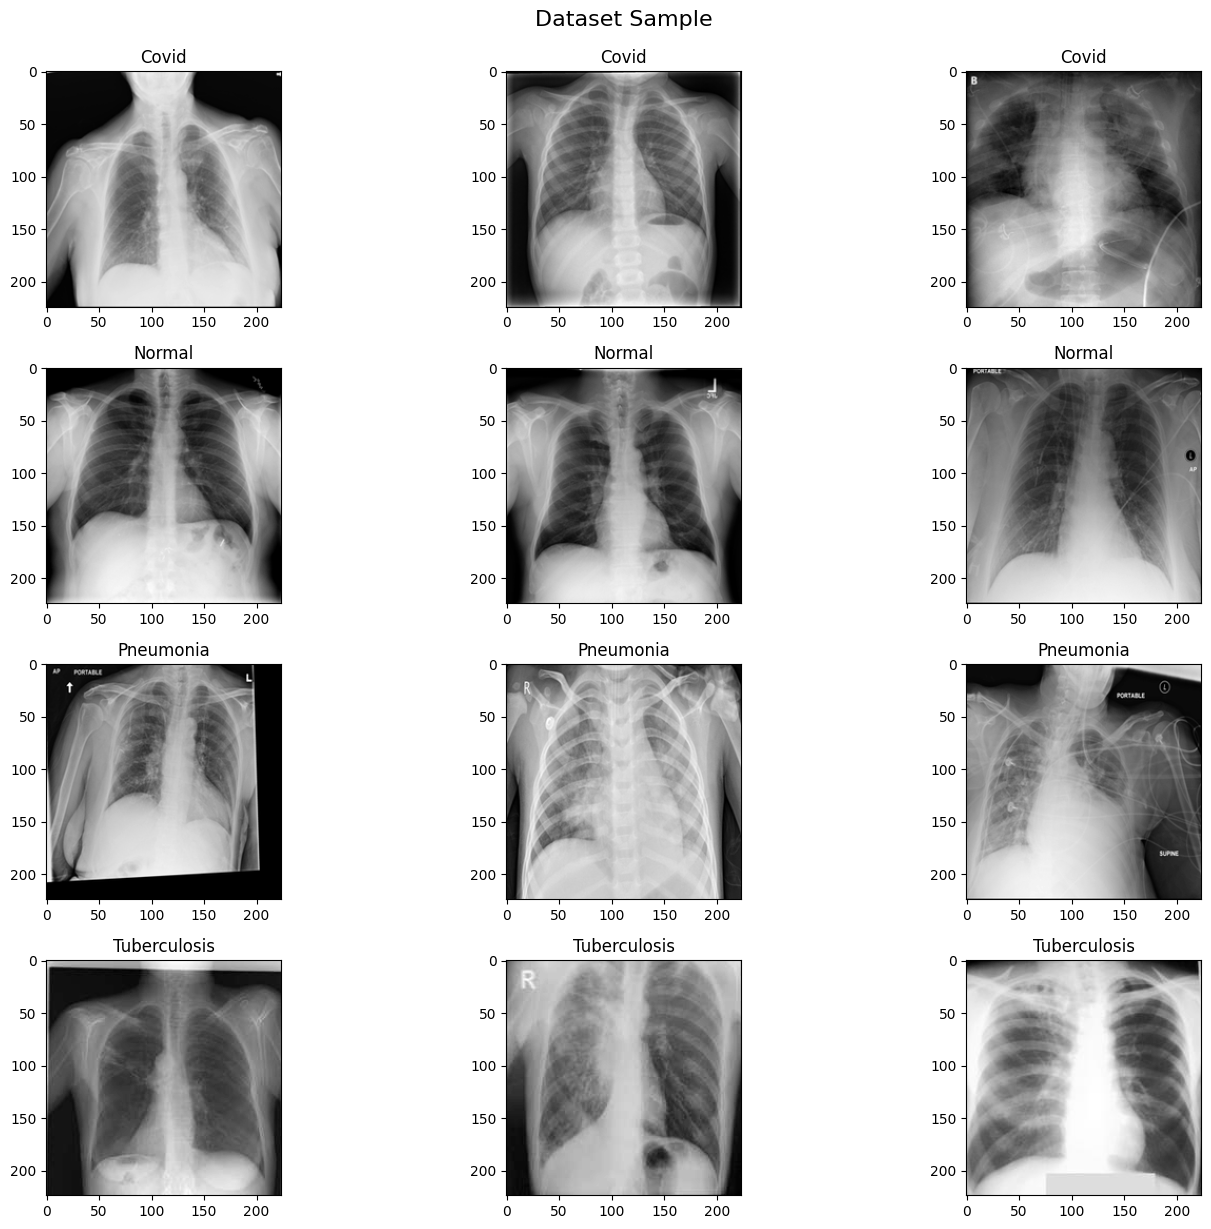

In [19]:
fig, axs = plt.subplots(num_classes, 3, figsize=(15, 12))

for i, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    images = os.listdir(class_dir)[:3]  # Select the first 3 images

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        ax = axs[i, j]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{label}", fontsize=12)

plt.tight_layout()

fig.suptitle('Dataset Sample', fontsize=16, y=1.02)

plt.show()

In [20]:
# Constants
num_classes = 4
input_shape = (224, 224)
batch_size = 64
num_epochs = 15
k_folds = 5

In [21]:
#Image Generator for train dataset
image_generator = ImageDataGenerator(rescale=1./255,
                                     shear_range=0.15,
                                     zoom_range=0.15,
                                     rotation_range=5, 
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     horizontal_flip=True,
                                     fill_mode="nearest",
                                     brightness_range=[0.75, 1.15], 
                                    )

#Image Generator for validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
# Define k-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_metrics = []
fold_accuracy = []

# Iterate over each class folder to collect file paths and labels
file_paths = []
labels = []
for i, class_label in enumerate(class_labels):
    class_folder = os.path.join(data_dir, class_label)
    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)
        file_paths.append(file_path)
        labels.append(i)

In [23]:
for fold, (train_indices, val_indices) in enumerate(skf.split(file_paths, labels)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Split data into training and validation sets
    train_file_paths = [file_paths[i] for i in train_indices]
    val_file_paths = [file_paths[i] for i in val_indices]
    train_labels = [labels[i] for i in train_indices]
    val_labels = [labels[i] for i in val_indices]

    # Create directories for train and val sets
    train_dir = os.path.join(data_dir, f'train_fold_{fold}')
    val_dir = os.path.join(data_dir, f'val_fold_{fold}')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Move training images to the train directory
    for file_path, label in zip(train_file_paths, train_labels):
        class_label = class_labels[label]
        target_dir = os.path.join(train_dir, class_label)
        os.makedirs(target_dir, exist_ok=True)
        target_path = os.path.join(target_dir, os.path.basename(file_path))
        shutil.copy(file_path, target_path)

    # Move validation images to the val directory
    for file_path, label in zip(val_file_paths, val_labels):
        class_label = class_labels[label]
        target_dir = os.path.join(val_dir, class_label)
        os.makedirs(target_dir, exist_ok=True)
        target_path = os.path.join(target_dir, os.path.basename(file_path))
        shutil.copy(file_path, target_path)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


Fold 1/5
Found 34183 images belonging to 4 classes.
Found 8545 images belonging to 4 classes.


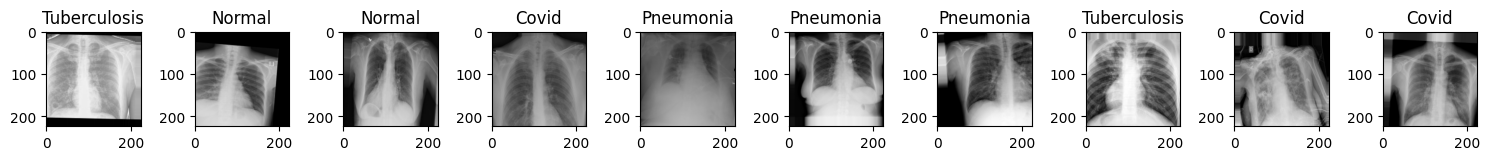

Epoch 1/15


2024-04-02 12:55:29.223305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 2.5289 - accuracy: 0.8184

2024-04-02 13:03:08.338731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/kylerimpos/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 551s 1s/step - loss: 2.5289 - accuracy: 0.8184 - val_loss: 1.0813 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 2/15
535/535 [==============================] - 482s 900ms/step - loss: 1.0702 - accuracy: 0.8696 - val_loss: 1.0515 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 3/15
535/535 [==============================] - 485s 905ms/step - loss: 0.9980 - accuracy: 0.8852 - val_loss: 1.0477 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 4/15
535/535 [==============================] - 491s 918ms/step - loss: 0.9860 - accuracy: 0.8908 - val_loss: 0.9976 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 5/15
535/535 [==============================] - ETA: 0s - loss: 0.9587 - accuracy: 0.8954
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
535/535 [==============================] - 484s 904ms/step - loss: 0.9587 - accuracy: 0.8954 - val_loss: 1.2315 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 6/15
535/535 [==============================] - 480s

2024-04-02 14:55:03.018362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 86s 622ms/step


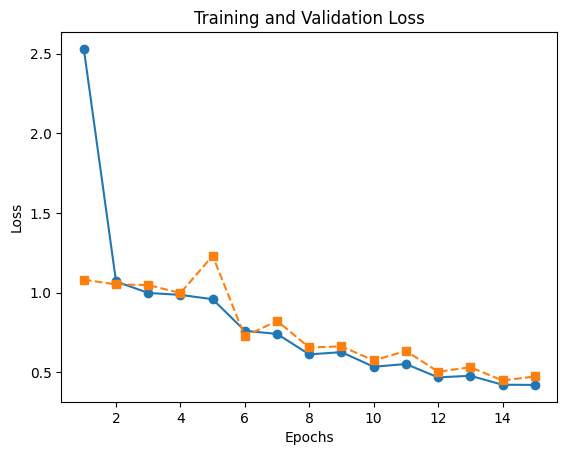

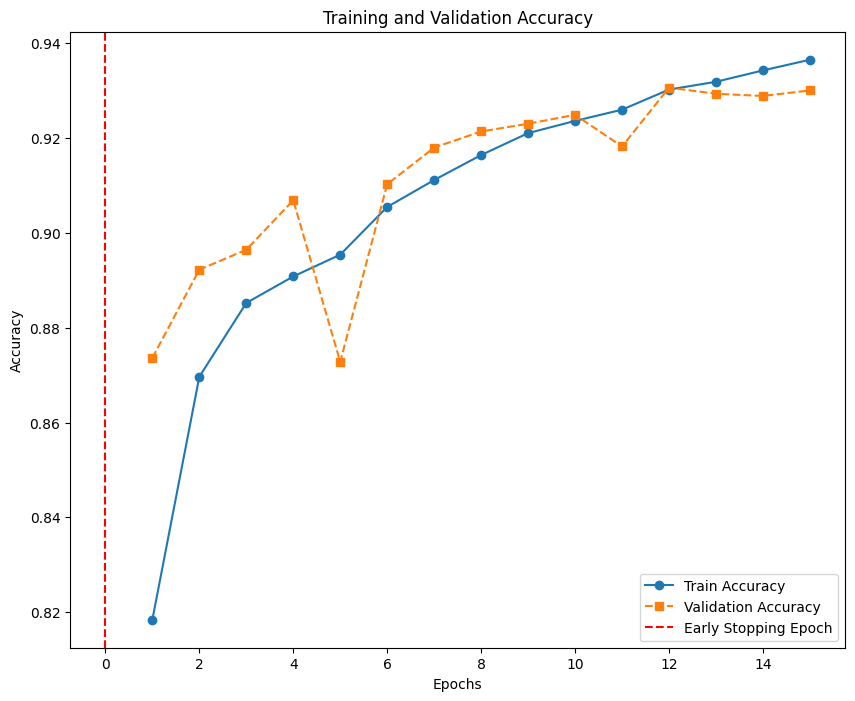

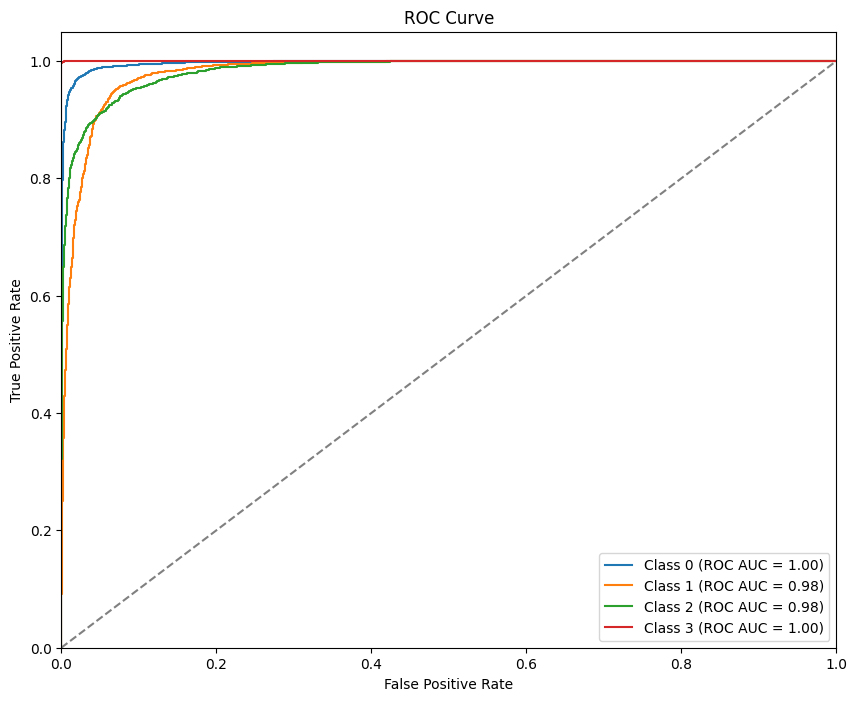

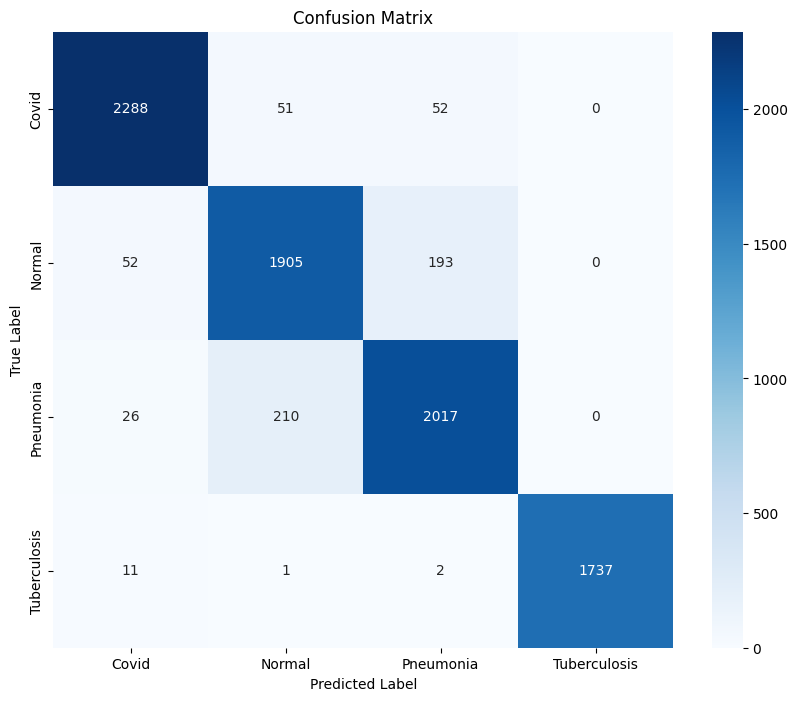

Accuracy: 0.9300175541252195
                     0            1            2            3  accuracy  \
precision     0.962558     0.879096     0.890901     1.000000  0.930018   
recall        0.956922     0.886047     0.895251     0.992005  0.930018   
f1-score      0.959732     0.882557     0.893071     0.995986  0.930018   
support    2391.000000  2150.000000  2253.000000  1751.000000  0.930018   

             macro avg  weighted avg  
precision     0.933139      0.930337  
recall        0.932556      0.930018  
f1-score      0.932836      0.930167  
support    8545.000000   8545.000000  
Fold 2/5
Found 34183 images belonging to 4 classes.
Found 8545 images belonging to 4 classes.
Epoch 1/15


2024-04-02 14:56:34.346801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 2.5244 - accuracy: 0.8184

2024-04-02 15:02:49.425171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/kylerimpos/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 464s 860ms/step - loss: 2.5244 - accuracy: 0.8184 - val_loss: 1.1523 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 2/15
535/535 [==============================] - ETA: 0s - loss: 1.0668 - accuracy: 0.8703
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
535/535 [==============================] - 452s 845ms/step - loss: 1.0668 - accuracy: 0.8703 - val_loss: 1.3296 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 3/15
535/535 [==============================] - 445s 832ms/step - loss: 0.8152 - accuracy: 0.8913 - val_loss: 0.8206 - val_accuracy: 0.8981 - lr: 7.0000e-04
Epoch 4/15
535/535 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.8993
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
535/535 [==============================] - 472s 882ms/step - loss: 0.7747 - accuracy: 0.8993 - val_loss: 0.8665 - val_accuracy: 0.9092 - lr: 7.0000e-04
Epoch 5/15
535/535 [=========================

2024-04-02 16:57:07.062627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 79s 574ms/step


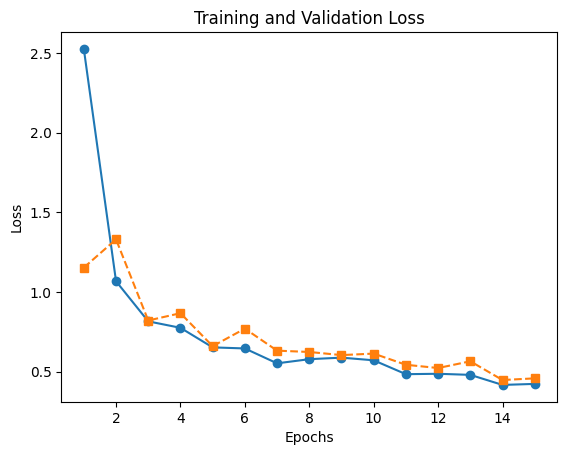

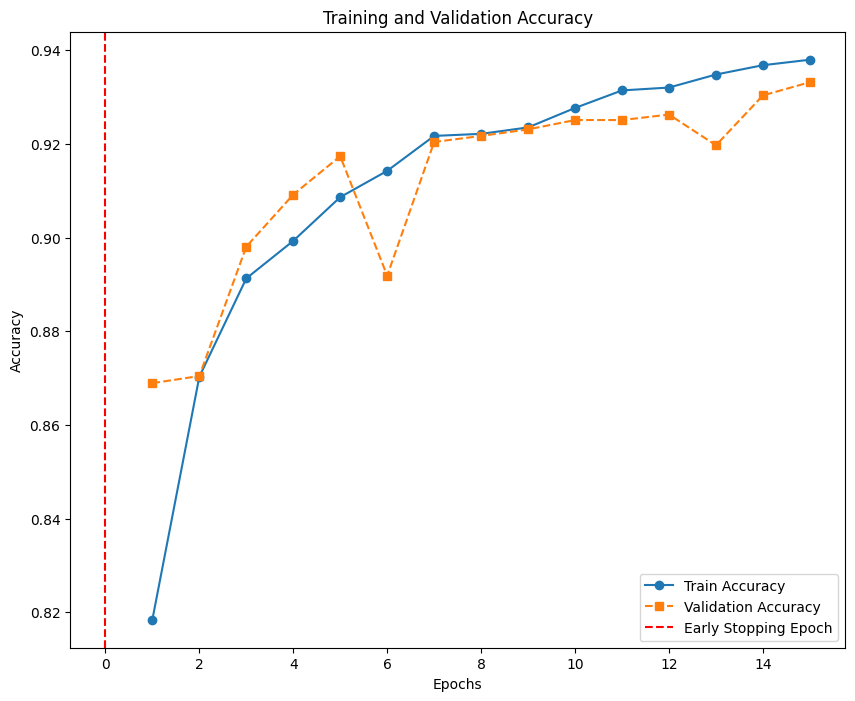

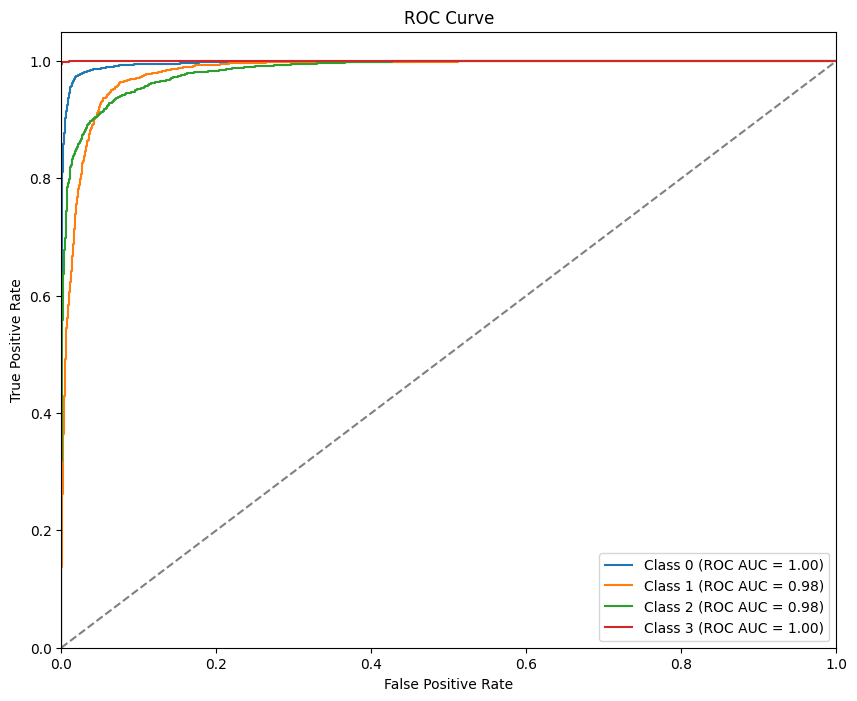

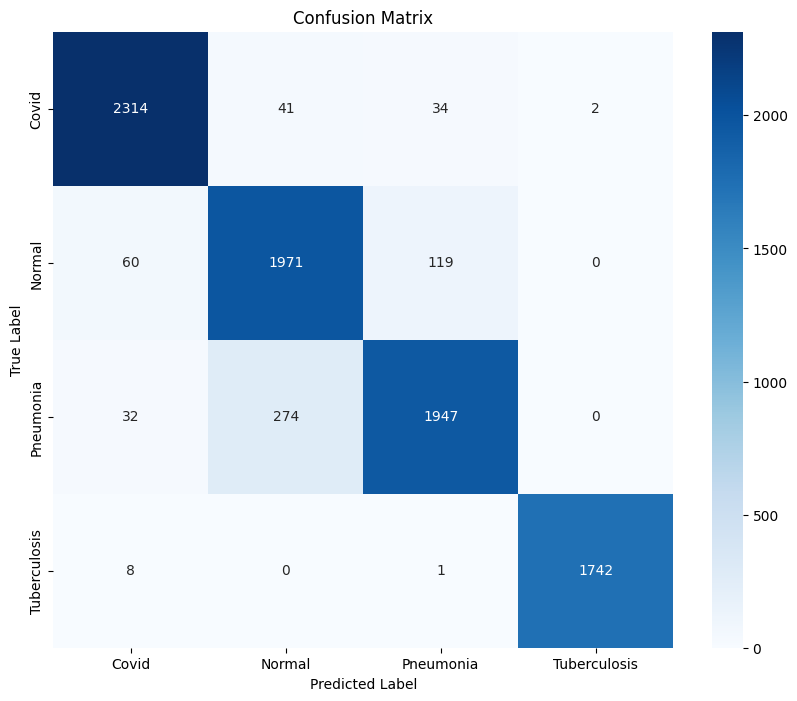

Accuracy: 0.9331772966647162
                     0            1            2            3  accuracy  \
precision     0.958575     0.862205     0.926702     0.998853  0.933177   
recall        0.967796     0.916744     0.864181     0.994860  0.933177   
f1-score      0.963163     0.888638     0.894350     0.996853  0.933177   
support    2391.000000  2150.000000  2253.000000  1751.000000  0.933177   

             macro avg  weighted avg  
precision     0.936584      0.934177  
recall        0.935895      0.933177  
f1-score      0.935751      0.933172  
support    8545.000000   8545.000000  
Fold 3/5
Found 34183 images belonging to 4 classes.
Found 8545 images belonging to 4 classes.
Epoch 1/15


2024-04-02 16:58:31.482216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 2.5474 - accuracy: 0.8171

2024-04-02 17:04:37.733951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/kylerimpos/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 457s 845ms/step - loss: 2.5474 - accuracy: 0.8171 - val_loss: 1.2672 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 2/15
535/535 [==============================] - 628s 1s/step - loss: 1.0681 - accuracy: 0.8686 - val_loss: 1.0985 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 3/15
535/535 [==============================] - 778s 1s/step - loss: 1.0905 - accuracy: 0.8754 - val_loss: 1.0804 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 4/15
535/535 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.8859
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
535/535 [==============================] - 713s 1s/step - loss: 1.0214 - accuracy: 0.8859 - val_loss: 1.1971 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 5/15
535/535 [==============================] - 635s 1s/step - loss: 0.7762 - accuracy: 0.8992 - val_loss: 0.8265 - val_accuracy: 0.9162 - lr: 7.0000e-04
Epoch 6/15
535/535 [==============================] - 595s 1s/s

2024-04-02 19:28:27.913862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 108s 785ms/step


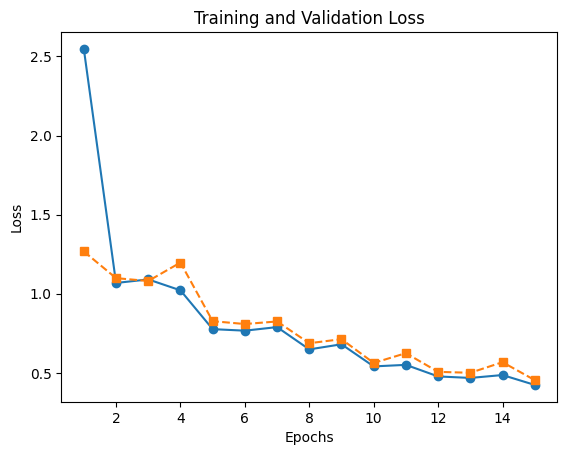

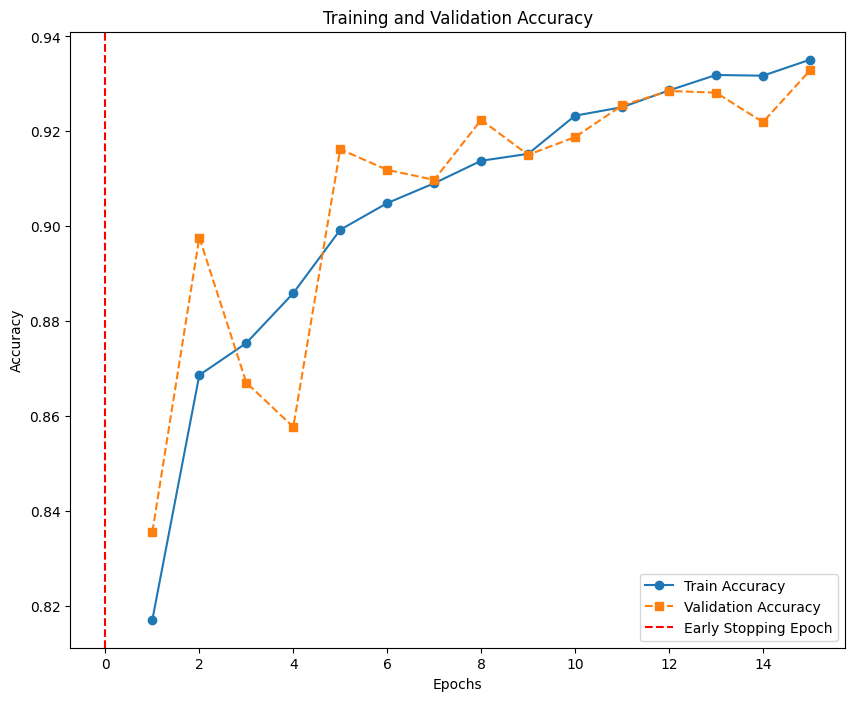

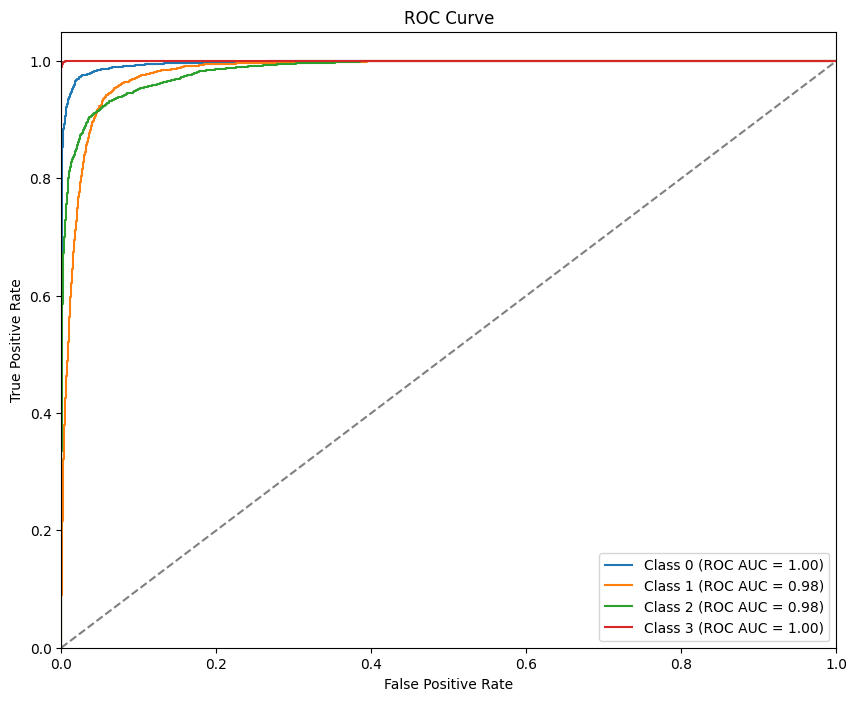

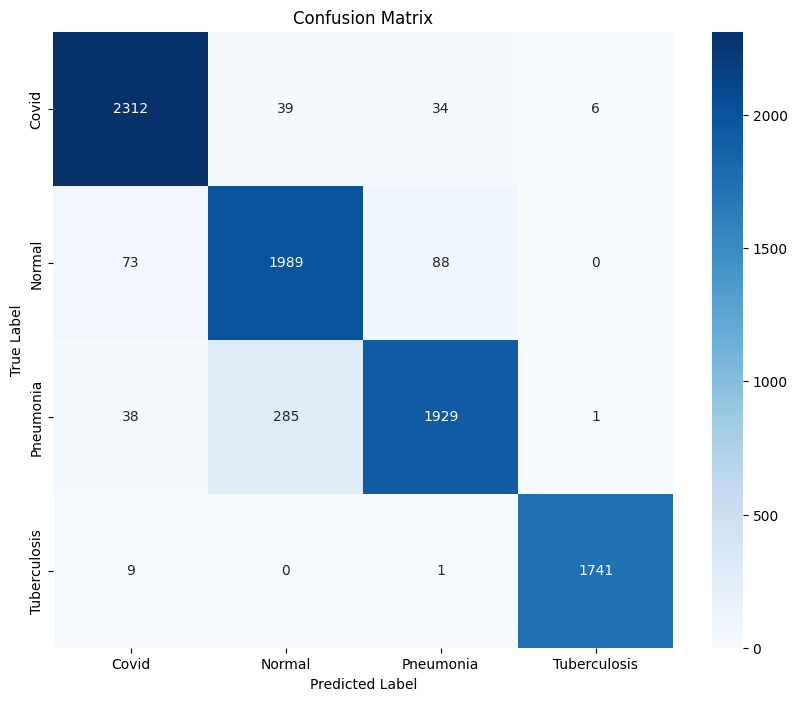

Accuracy: 0.9328262141603276
                     0            1            2            3  accuracy  \
precision     0.950658     0.859922     0.940058     0.995995  0.932826   
recall        0.966959     0.925116     0.856192     0.994289  0.932826   
f1-score      0.958739     0.891329     0.896167     0.995141  0.932826   
support    2391.000000  2150.000000  2253.000000  1751.000000  0.932826   

             macro avg  weighted avg  
precision     0.936658      0.934324  
recall        0.935639      0.932826  
f1-score      0.935344      0.932740  
support    8545.000000   8545.000000  
Fold 4/5
Found 34183 images belonging to 4 classes.
Found 8545 images belonging to 4 classes.
Epoch 1/15


2024-04-02 19:30:29.554419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 2.4970 - accuracy: 0.8188

2024-04-02 19:38:48.789235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/kylerimpos/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 608s 1s/step - loss: 2.4970 - accuracy: 0.8188 - val_loss: 1.3504 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 2/15
535/535 [==============================] - 619s 1s/step - loss: 1.0783 - accuracy: 0.8688 - val_loss: 1.0978 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 3/15
535/535 [==============================] - 534s 998ms/step - loss: 0.9936 - accuracy: 0.8846 - val_loss: 1.0850 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 4/15
535/535 [==============================] - 451s 844ms/step - loss: 0.9662 - accuracy: 0.8908 - val_loss: 1.0413 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 5/15
535/535 [==============================] - 411s 768ms/step - loss: 0.9204 - accuracy: 0.8971 - val_loss: 1.0368 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 6/15
535/535 [==============================] - ETA: 0s - loss: 0.9052 - accuracy: 0.9000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
535/535 [==============================] - 413s 77

2024-04-02 21:29:30.164696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 101s 730ms/step


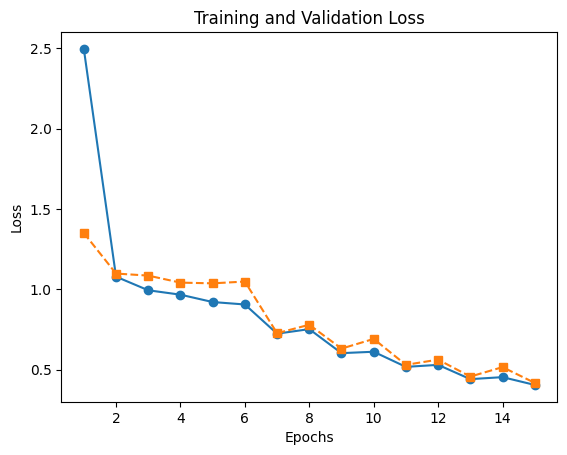

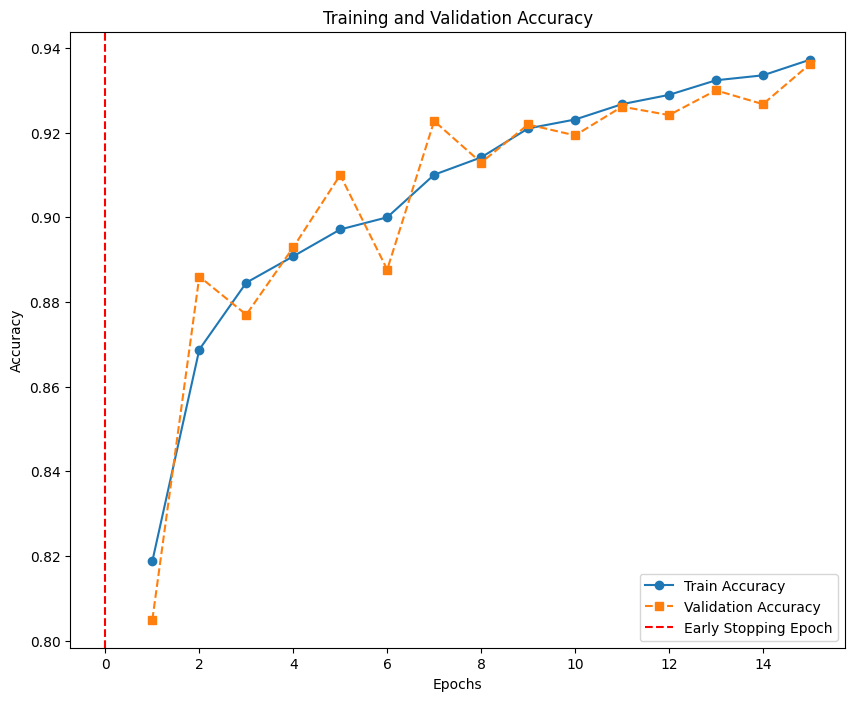

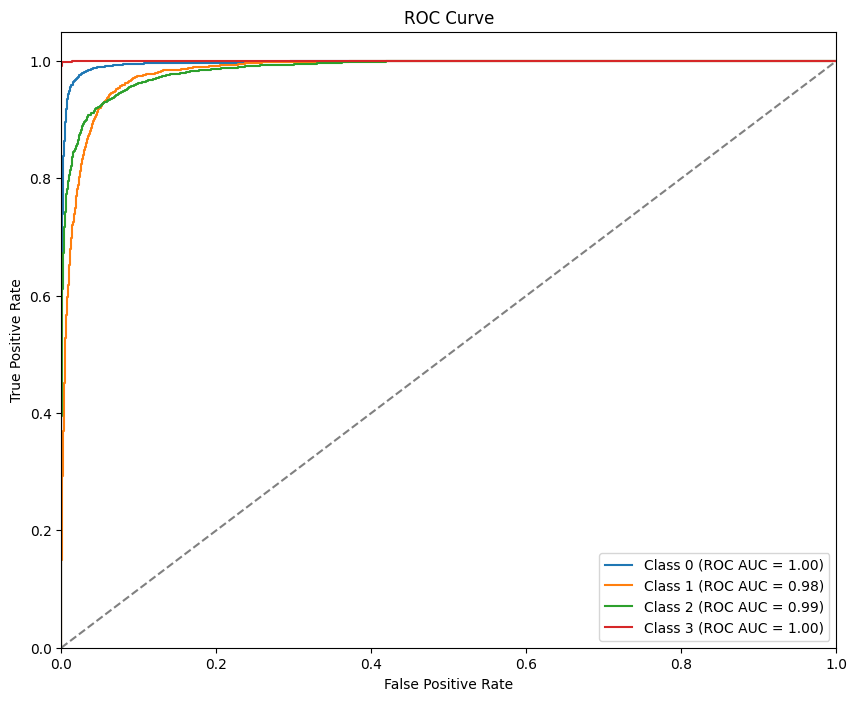

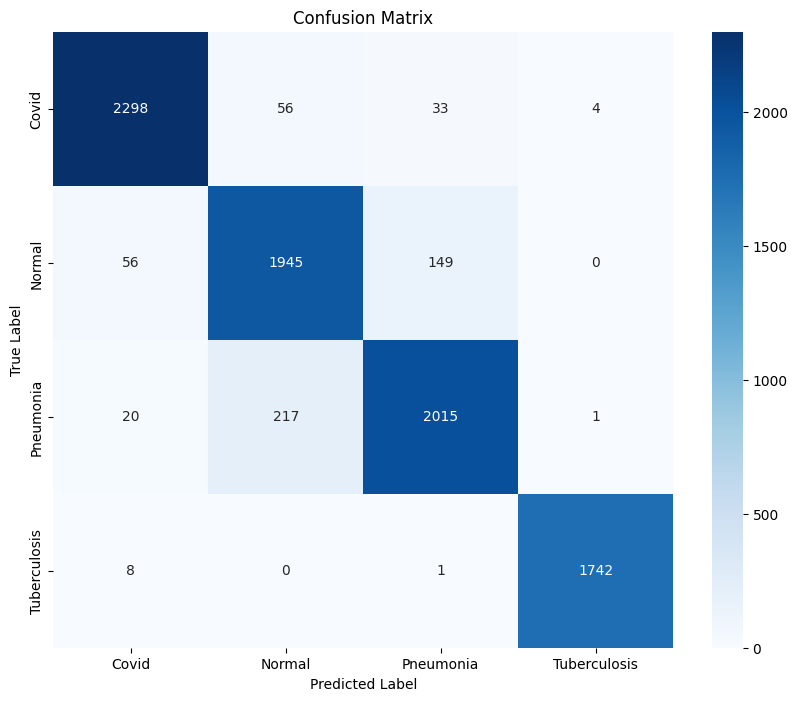

Accuracy: 0.9362200117027502
                     0            1            2            3  accuracy  \
precision     0.964736     0.876916     0.916742     0.997138   0.93622   
recall        0.961104     0.904651     0.894363     0.994860   0.93622   
f1-score      0.962916     0.890568     0.905415     0.995998   0.93622   
support    2391.000000  2150.000000  2253.000000  1751.000000   0.93622   

             macro avg  weighted avg  
precision     0.938883      0.936625  
recall        0.938745      0.936220  
f1-score      0.938724      0.936331  
support    8545.000000   8545.000000  
Fold 5/5
Found 34183 images belonging to 4 classes.
Found 8545 images belonging to 4 classes.
Epoch 1/15


2024-04-02 21:31:22.761071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 2.5255 - accuracy: 0.8180

2024-04-02 21:38:34.090291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/kylerimpos/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 539s 998ms/step - loss: 2.5255 - accuracy: 0.8180 - val_loss: 1.1841 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 2/15
535/535 [==============================] - 531s 990ms/step - loss: 1.0944 - accuracy: 0.8675 - val_loss: 1.0868 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 3/15
535/535 [==============================] - 539s 1s/step - loss: 1.0415 - accuracy: 0.8790 - val_loss: 1.0118 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 4/15
535/535 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.8856
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
535/535 [==============================] - 652s 1s/step - loss: 0.9941 - accuracy: 0.8856 - val_loss: 1.0470 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 5/15
535/535 [==============================] - 715s 1s/step - loss: 0.7484 - accuracy: 0.9013 - val_loss: 0.8053 - val_accuracy: 0.9088 - lr: 7.0000e-04
Epoch 6/15
535/535 [==============================] - ETA: 0

2024-04-03 00:14:13.331321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 89s 628ms/step


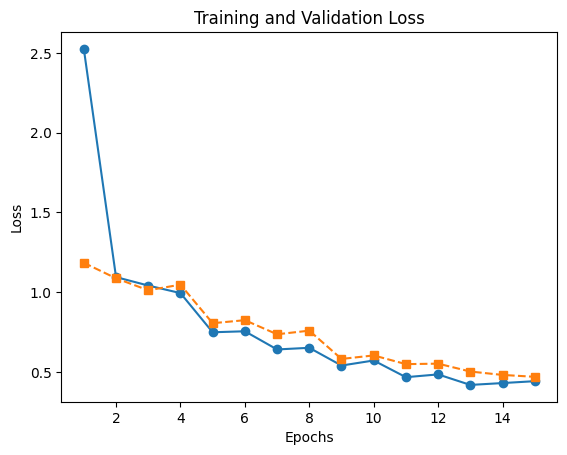

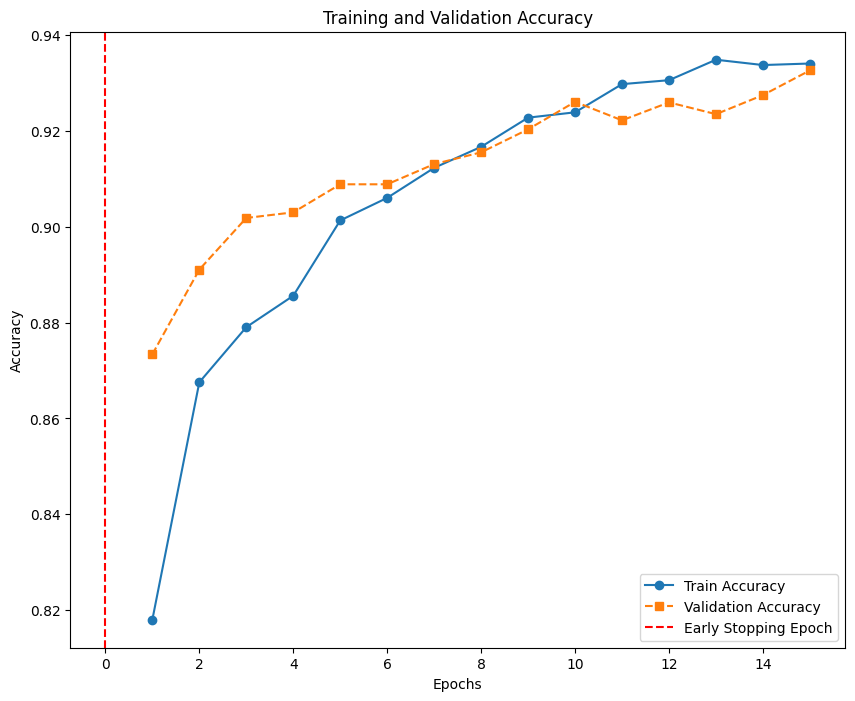

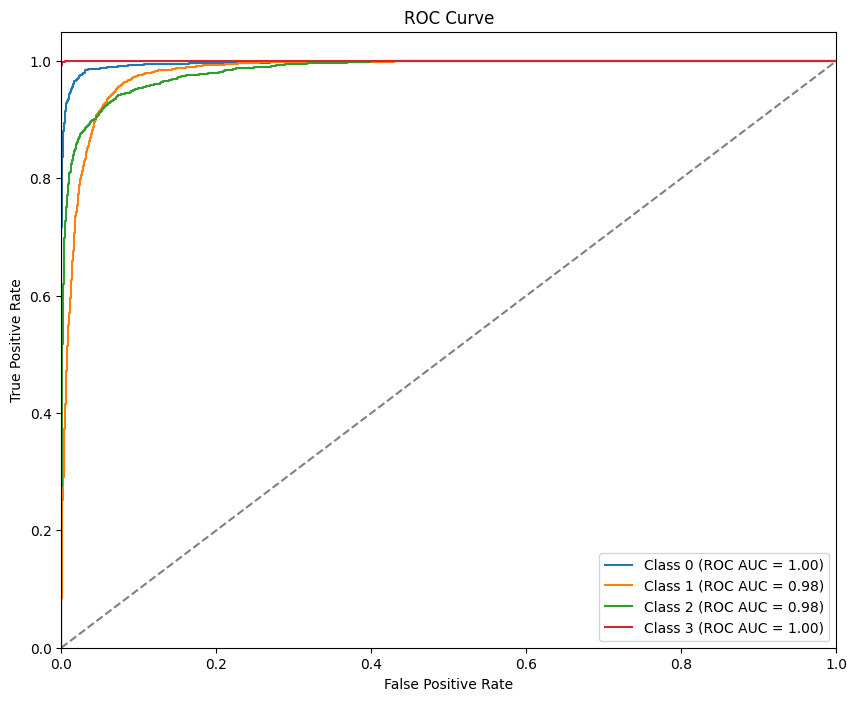

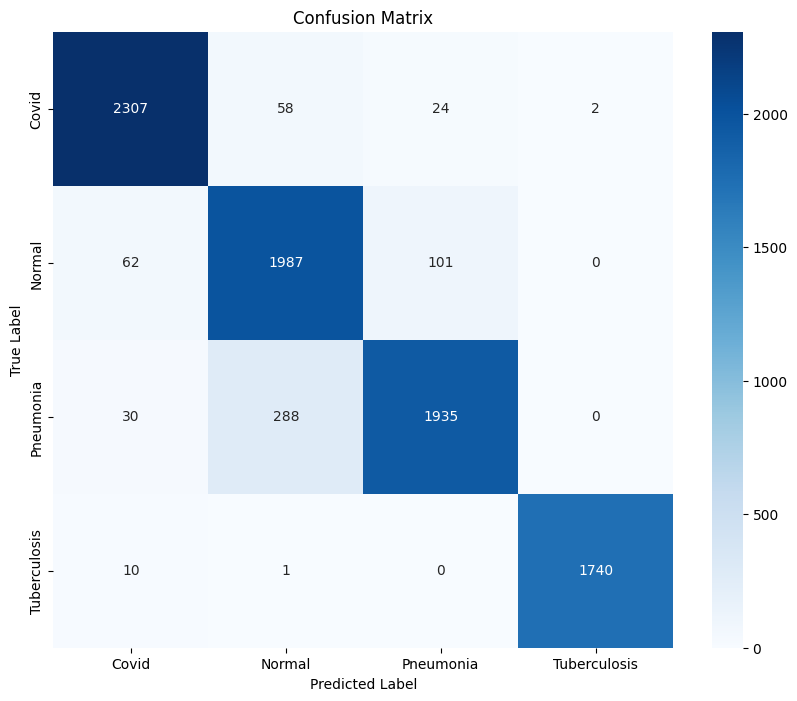

Accuracy: 0.932592159157402
                     0            1            2            3  accuracy  \
precision     0.957659     0.851328     0.939320     0.998852  0.932592   
recall        0.964868     0.924186     0.858855     0.993718  0.932592   
f1-score      0.961250     0.886262     0.897287     0.996278  0.932592   
support    2391.000000  2150.000000  2253.000000  1751.000000  0.932592   

             macro avg  weighted avg  
precision     0.936790      0.934511  
recall        0.935407      0.932592  
f1-score      0.935269      0.932696  
support    8545.000000   8545.000000  


In [24]:
# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(skf.split(file_paths, labels)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Define and compile model outside the loop
    base_model = DenseNet121(weights='imagenet', include_top=False)
    
    # Freeze the layers of the pre-trained model up to a certain point
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-30:]:
        layer.trainable = True 
        
    # Incorporate attention mechanism into the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, 
              kernel_regularizer = regularizers.l2(l2 = 0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006) ,
              activation='relu')(x)
    x = Dropout(0.3, seed=123)(x)  # Add dropout layer to prevent overfitting
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Define the optimizer with a custom learning rate
    optimizer = Adam(learning_rate=0.001)
    
    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.7, 
                                  patience=1, 
                                  verbose=1, 
                                  min_lr=1e-7
                                 )
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss for early stopping
                                   patience=2,          # Number of epochs with no improvement after which training will be stopped
                                   restore_best_weights=True  # Restore the best model weights based on validation loss
                                  )
    model_checkpoint = ModelCheckpoint(f'Model_fold_{fold + 1}.h5', 
                                       monitor='val_loss', 
                                       save_best_only=True)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Create data generators for training and validation
    train_data_generator = image_generator.flow_from_directory(train_dir,
                                                               target_size=input_shape,
                                                               batch_size=batch_size,
                                                               class_mode='categorical',
                                                               shuffle=True,
                                                               color_mode='rgb',
                                                               seed=42
                                                              )

    
    val_data_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )

    if fold == 0:
        # Generate augmented images
        augmented_images, lbl = next(train_data_generator)
        
        # Display the augmented images
        plt.figure(figsize=(15, 10))  # Adjust the figure size for larger images
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(augmented_images[i])
            plt.title(f"{class_labels[np.argmax(lbl[i])]}")
        plt.tight_layout()
        plt.show()

    

    history = model.fit(train_data_generator,
                        epochs=num_epochs,
                        validation_data=val_data_generator,
                        verbose=1,
                        callbacks=[reduce_lr, early_stopping, model_checkpoint]
                        )
    
    # Make predictions on validation data
    y_true = val_data_generator.classes
    y_pred_proba = model.predict(val_data_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Generate classification report
    classification_rep = classification_report(y_true, y_pred, output_dict=True)
    
    # Calculate confusion matrixhgfjjdgrerfddfrfddrfddrrfrdfrddddfdddrdddfrddrddddfdfdffdddddedfgjhffcx
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate precision, recall, and F1-score for each class
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)


    # Calculate precision-recall curve and AUC
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    pr_auc = average_precision_score(y_true_bin, y_pred_proba, average='macro')
    
    # Calculate ROC curve and ROC AUC for each class (one-vs-rest)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fold_metrics.append({
        'classification_report': classification_rep,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'precision_recall_auc': pr_auc,
        'roc_curve': (fpr, tpr),
        'roc_auc': roc_auc,
        'y_true' : y_true,
        'y_pred_proba': y_pred_proba,
        'y_pred' : y_pred
    })

    # Plot training and validation loss vs. epochs
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', marker='o', linestyle='-')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Plot accuracy curve
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy',marker='o', linestyle='-')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy', marker='s', linestyle='--')
    plt.axvline(x=early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot ROC curve for each class (one-vs-rest)
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (ROC AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate total correct predictions
    total_correct = np.trace(cm)
    
    # Calculate total predictions
    total_predictions = np.sum(cm)
    
    # Calculate accuracy
    accuracy = total_correct / total_predictions
    fold_accuracy.append(accuracy)
    print(f"Accuracy: {accuracy}")

    # Generate classification report
    classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_dict)
    print(classification_report_df)

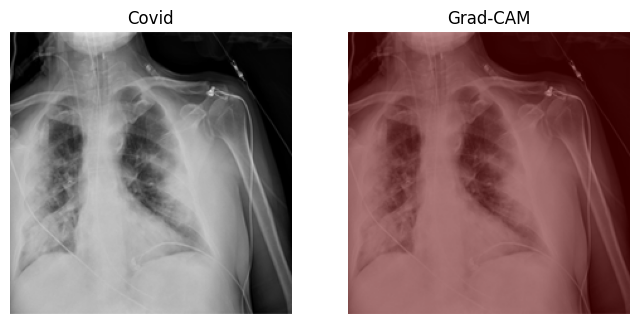

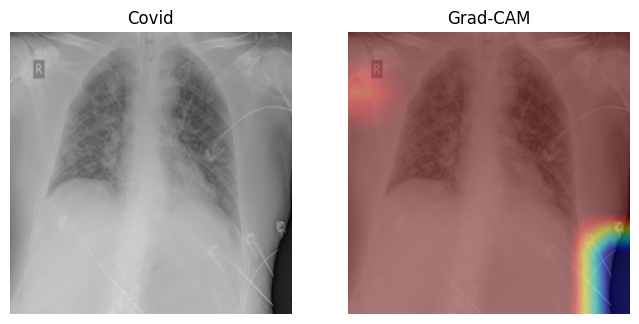

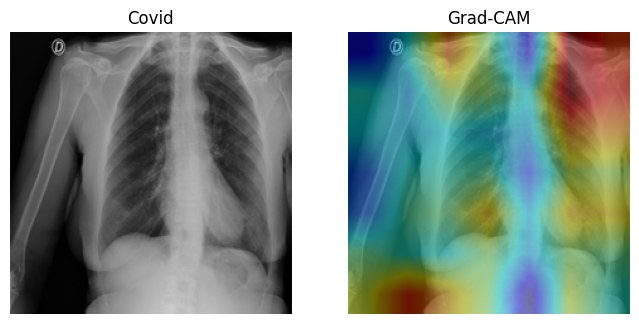

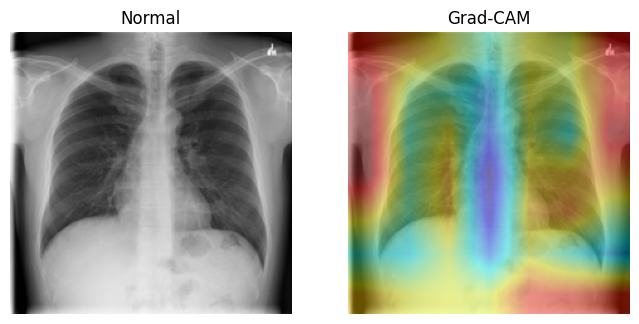

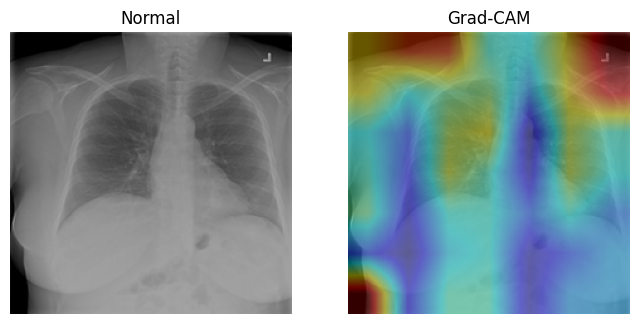

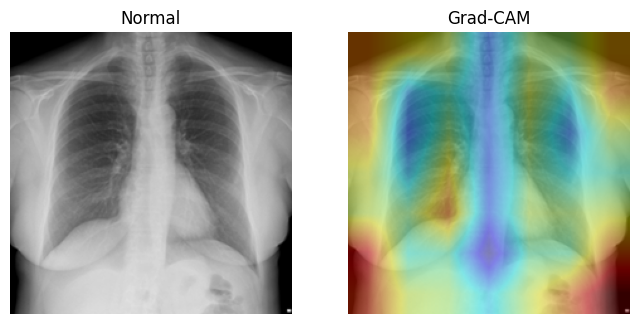

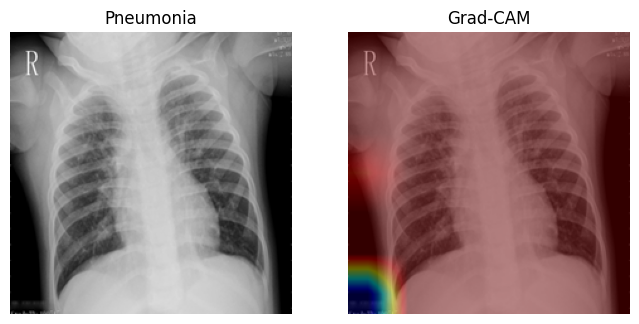

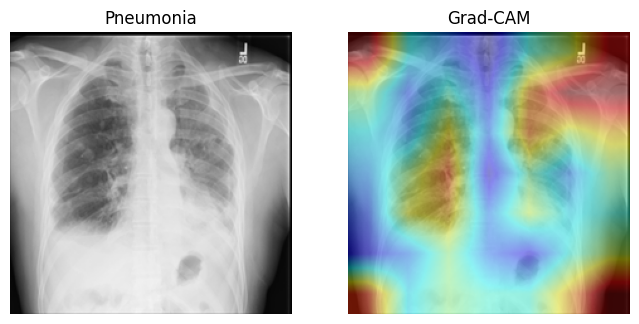

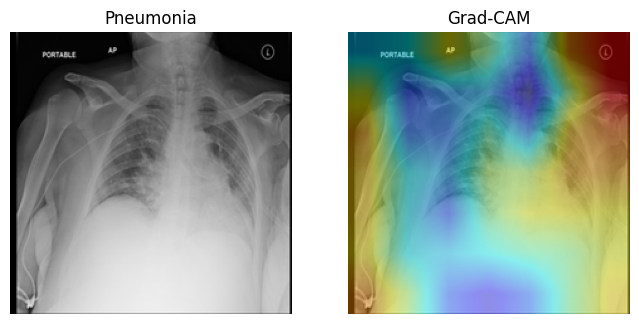

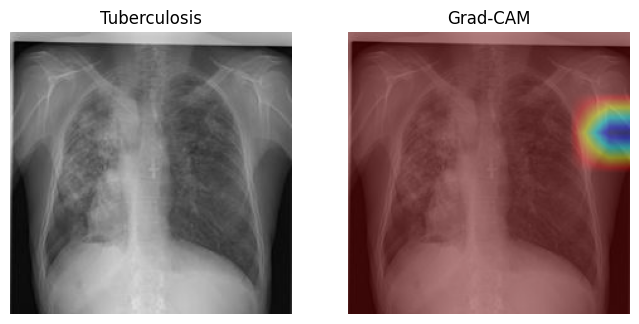

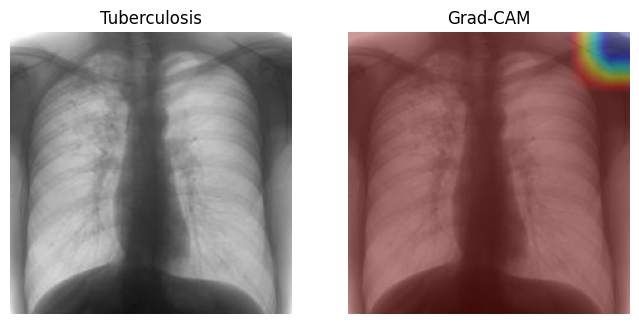

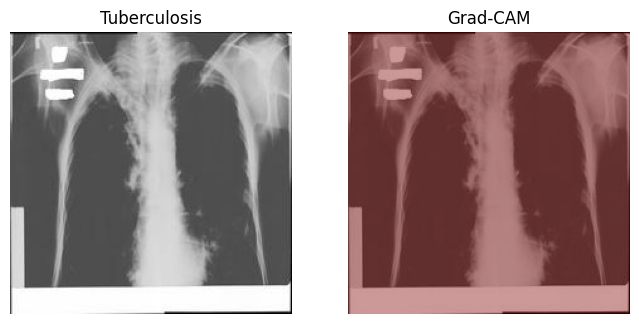

In [51]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

def compute_grad_cam(model, img_path, class_index, layer_name):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img_array = img / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Create a model that maps the input image to the activations of the target layer and the output predictions
    grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])

    # Compute the gradient of the predicted class with respect to the activations of the target layer
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        output = preds[:, class_index]

    grads = tape.gradient(output, last_conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the class
    last_conv_output = last_conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(last_conv_output, pooled_grads), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the input image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img


# Get the list of subdirectories (class labels) in the dataset directory

dataset_dir = './DATASET/'
# Sample 10 images from each class for Grad-CAM visualization
num_samples_per_class = 3
for label in class_labels:
    class_dir = os.path.join(dataset_dir, label)
    img_paths = os.listdir(class_dir)
    sample_img_paths = np.random.choice(img_paths, num_samples_per_class, replace=False)
    
    # Compute Grad-CAM for each sampled image
    for img_name in sample_img_paths:
        img_path = os.path.join(class_dir, img_name)
        label_index = class_labels.index(label)
        
        # Compute Grad-CAM
        grad_cam_img = compute_grad_cam(model, img_path, class_index=label_index, layer_name='conv5_block16_concat')
        
        # Display the original image and Grad-CAM visualization
        plt.figure(figsize=(8, 4))
        
        # Original image
        plt.subplot(1, 2, 1)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f'{label}')
        plt.axis('off')
        
        # Grad-CAM visualization
        plt.subplot(1, 2, 2)
        plt.imshow(grad_cam_img)
        plt.title('Grad-CAM')
        plt.axis('off')
        
        plt.show()


In [55]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, None, None, 3)        0         ['input_7[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d_12[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']    